# Pre-Processing Data

This notebook should get all the relevant data, convert it into data of the same size and then save this new data. If a piece of data has enough data to be converted into many data points, it should be.

In [675]:
import os
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# From Joao Maio on Piazza
target_folder = Path('.')/'..'/'pdiot-data'/'2020'

student_pattern = "s\d{7}"

files = {}
for (dirpath, dirnames, filenames) in os.walk(target_folder):
  s_match = re.search(student_pattern, dirpath)
  # if regex matches, and files exist
  if s_match and filenames:
    s = s_match.group()
    #print(f"adding files for {s} (in {dirpath})")
    dir = Path(dirpath)
    try: files[s]
    except KeyError: files[s] = []
    # only accept .csv files
    files[s].extend([dir/f for f in filenames if f[-4:] == '.csv'])

print("File count:")
print({k: len(v) for (k, v) in files.items()})

File count:
{'s1621503': 84, 's1746788': 84, 's1701688': 84, 's1735229': 84, 's1710228': 84, 's1737472': 78, 's1704037': 80, 's2017768': 11, 's1768094': 165, 's1770036': 78, 's1721039': 81, 's1616573': 94, 's1709221': 71, 's1655560': 78, 's1711507': 233, 's1655552': 90, 's1764751': 92, 's1642301': 84, 's1751093': 79, 's2124639': 89, 's1758009': 78, 's1758499': 84, 's1660711': 84, 's1736273': 84}


In [720]:
activity_dict = {
    0: "Sitting",
    4: "Sitting bent forward",
    5: "Sitting bent backward",
    1: "Walking at normal speed",
    100: "Standing",
    2: "Lying down on back",
    7: "Lying down left",
    6: "Lying down right",
    8: "Lying down on stomach",
    9: "Movement",
    11: "Running",
    12: "Climbing stairs",
    13: "Descending stairs",
    31: "Desk work"}

In [582]:
# From Teodora Georgescu on Piazza
def read_old_file_format(file_path):
    """
    Reads the recording files that do not contain headers.
    """
    pdiot_data = pd.read_csv(file_path)
    
    ACTIVITY_CODE_TO_NAME_MAPPING = {
        0: "Sitting",
        4: "Sitting bent forward",
        5: "Sitting bent backward",
        1: "Walking at normal speed",
        100: "Standing",
        2: "Lying down on back",
        7: "Lying down left",
        6: "Lying down right",
        8: "Lying down on stomach",
        9: "Movement",
        11: "Running",
        12: "Climbing stairs",
        13: "Descending stairs",
        31: "Desk work"}
    
    pdiot_header_information = dict()
    pdiot_header_information["Sensor position"] = pdiot_data['sensor_position'].values[0]
    pdiot_header_information["Sensor side"] = pdiot_data['sensor_side'].values[0]
    pdiot_header_information["Activity type"] = ACTIVITY_CODE_TO_NAME_MAPPING[pdiot_data['activity_type'].values[0]]
    pdiot_header_information["Activity code"] = pdiot_data['activity_type'].values[0]
    pdiot_header_information["Subject id"] = pdiot_data['subject_id'].values[0]
    
    pdiot_data.drop(columns=['sensor_position','sensor_side', 'subject_id', 'activity_type', 'recording_id'], inplace=True)
    
    return pdiot_data, pdiot_header_information

In [670]:
# Change depending on what sensor position you want.
def get_data(desired_position):
    desired = []
    for student in files:
        desired = desired + ([f for f in files[student] if desired_position in str(f)])
    len(desired)

    header_size = 5
    data = []
    for d in desired:
        read = pd.read_csv(d, skiprows=5)
        if 'timestamp' not in read.columns:
            read, head = read_old_file_format(d)
        else:
            with open(d) as f:
                head = [next(f).rstrip().split('# ')[1] for x in range(header_size)]
        data.append((head,read))
    return data

In [506]:
def get_seconds(data):
    ts = data[1]['timestamp']
    start = ts[0]
    end = ts[len(ts)-1]
    return (end-start) / 1000, start, end
    

In [518]:
def get_data_by_time(data,time_wanted):
    #time_wanted = 20
    new_data = []
    for d in data:
        main = d[1]
        if len(main) == 0:
            continue
        time, start, end = get_seconds(d)
        if time >= time_wanted + 2:
            # print(get_seconds(d))
            # shave of first and last second
            start = start + 1000
            end = end - 1000
            mask = (main['timestamp'] >= start) & (main['timestamp'] <= end)
            main = main[mask]
            repeats = time / time_wanted
            for r in range(int(repeats)):
                seconds = time_wanted * 1000
                intstart = start + (seconds * r)
                intend = intstart + seconds
                #print((intend-intstart)/1000)
                #print("r", r)
                #print("s", start) 
                #print("e", intend)
                mask = (main['timestamp'] >= intstart) & (main['timestamp'] <= intend)
                new = main[mask].reset_index(drop=True)
                #print(new)
                new_data.append((list(d[0]), new))
    return new_data


In [519]:
new_data = get_data_by_time(data, 20)
len(new_data)

350

In [794]:
sitting = [{'data': d[1].filter(['accel_x','accel_y','accel_z']), 'target': int(d[0][3].split(':')[1])} for d in new_data if "Sitting" in d[0][2] ]
walking = [{'data': d[1].filter(['accel_x','accel_y','accel_z']), 'target': int(d[0][3].split(':')[1])} for d in new_data if "Walking" in d[0][2] and d[1].shape[0]<500 and d[1].shape[0]>0]
standing = [{'data': d[1].filter(['accel_x','accel_y','accel_z']), 'target': int(d[0][3].split(':')[1])} for d in new_data if "Standing" in d[0][2] and d[1].shape[0]<500 and d[1].shape[0]>0]
lying = [{'data': d[1].filter(['accel_x','accel_y','accel_z']), 'target': int(d[0][3].split(':')[1])} for d in new_data if "Lying" in d[0][2] and d[1].shape[0]<500 and d[1].shape[0]>0]
movement = [{'data': d[1].filter(['accel_x','accel_y','accel_z']), 'target': int(d[0][3].split(':')[1])} for d in new_data if "Movement" in d[0][2] and d[1].shape[0]<500 and d[1].shape[0]>0]
running = [{'data': d[1].filter(['accel_x','accel_y','accel_z']), 'target': int(d[0][3].split(':')[1])} for d in new_data if "Running" in d[0][2] and d[1].shape[0]<500 and d[1].shape[0]>0]
climb_stairs = [{'data': d[1].filter(['accel_x','accel_y','accel_z']), 'target': int(d[0][3].split(':')[1])} for d in new_data if "Climbing stairs" in d[0][2] and d[1].shape[0]<500 and d[1].shape[0]>0]
descend_stairs = [{'data': d[1].filter(['accel_x','accel_y','accel_z']), 'target': int(d[0][3].split(':')[1])} for d in new_data if "Descending stairs" in d[0][2] and d[1].shape[0]<500 and d[1].shape[0]>0]
desk_work = [{'data': d[1].filter(['accel_x','accel_y','accel_z']), 'target': int(d[0][3].split(':')[1])} for d in new_data if "Desk work" in d[0][2] and d[1].shape[0]<500 and d[1].shape[0]>0]

KeyError: 0

In [521]:
len(desk_work)

18

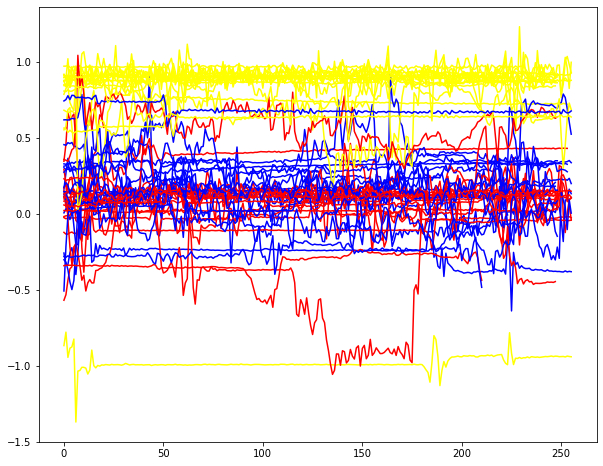

In [522]:
fig = plt.figure(figsize=(10, 8))

for s in desk_work:    
    plt.plot(s['data']['accel_x'],c='red')
    plt.plot(s['data']['accel_y'],c='blue')
    plt.plot(s['data']['accel_z'],c='yellow')

In [503]:
shapes = []
for d in desk_work:
    shapes.append(d['data'].shape[0])
print(shapes)

[247, 256, 224, 256, 256, 254, 254, 249, 256, 256, 256, 249, 248, 249, 211, 256, 249, 248]


In [659]:
def get_data_by_datapoints(data, points_wanted=50, overlap=0.5):
    new_data = []
    new_targets = []
    for d in data:
        main = d[1]
        if len(d[1]) == 0:
            continue
        if type(d[0]) != dict:
            target = int(d[0][3].split(':')[1])
        else:
            target = d[0]["Activity code"]
        # Shave of first and last second
        start = main['timestamp'][0]
        end = main['timestamp'][len(main['timestamp'])-1]
        mask = (main['timestamp'] >= start+1000) & (main['timestamp'] <= end-1000)
        main = main[mask].reset_index(drop=True)
        iters = main.shape[0] / points_wanted
        #print(main.shape[0])
        #print(iters/overlap)
        start = 0
        end = points_wanted
        for i in range(int(iters/overlap)-1):
            new_data.append(main[start:end].filter(['accel_x','accel_y','accel_z']).reset_index(drop=True))
            new_targets.append(target)
            start += int(points_wanted * overlap)
            end = int(start + points_wanted)
    return new_data, new_targets

In [677]:
data = get_data("Chest_Left")
cleaned_data, targets = get_data_by_datapoints(data, points_wanted = 50, overlap=0.5)

In [678]:
len(cleaned_data)

8349

In [679]:
len(targets)

8349

In [680]:
n = np.array(targets)

In [689]:
c = np.array(cleaned_data)

In [726]:
for k,v in activity_dict.items():
    print("{:<25} {} ".format(v, len(c[n==k])))
print(len(activity_dict))

Sitting                   709 
Sitting bent forward      657 
Sitting bent backward     622 
Walking at normal speed   705 
Standing                  603 
Lying down on back        628 
Lying down left           670 
Lying down right          577 
Lying down on stomach     624 
Movement                  403 
Running                   547 
Climbing stairs           500 
Descending stairs         473 
Desk work                 631 
14


In [753]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [803]:
c_new = [p.flatten() for p in c]

In [804]:
X_train, X_test, y_train, y_test = train_test_split(c_new, n, test_size=0.33, random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.7256894049346879

## Finding K

In [789]:
scores = []
for k in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    scores.append(score)

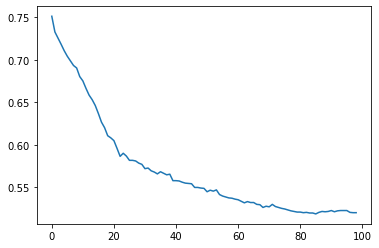

In [793]:
plt.plot(scores)

In [779]:
np.argmax(scores)

0